#Part5. [실습1] 보험료 예측



## 01. 데이터 소개 및 분석프로세스 수립
 → [강의자료]-[강의교안]-[Ch1.보험료 예측] 참고

In [1]:
############################################## 00. 필요한 파이썬 라이브러리 불러오기 #####################################################
import pandas as pd
import numpy as np
import seaborn as sns
import missingno

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt 

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score

## 02. 데이터 준비를 위한 EDA 및 전처리
#### 데이터는 [강의자료]-[실습데이터]의 [ch1_premium.csv] 를 이용합니다.
---
[EDA 체크리스트]
1. 어떤 질문을 풀거나 틀렸다고 증명하려고 하는가?
2. 중복된 항목은 있는가?
3. 어떤 종류의 데이터가 있으며 다른 데이터 타입들을 어떻게 다루려고 하는가?
4. 데이터에서 누락된 것이 있는지, 있다면 그것들을 어떻게 처리하려는가?
5. 이상치는 어디에 있는가? 관심을 가져야 할 데이터인가?
6. 변수 간 상관성이 있는가?
---

### 0. 데이터 불러오기



In [2]:
## 구글 드라이브 마운트가 필요할 시 주석 해제
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
############################################## 01. 실습 데이터 불러오기 #####################################################
data = pd.read_csv("../3. Data/Ch 03/ch3_premium.csv")

### 1. 어떤 질문을 풀거나 틀렸다고 증명하려고 하는가?
> 보험사 고객 정보를 통해 보험료 예측 모델을 생성하려고 한다.

> 간략하게 데이터 살피기

In [4]:
data.head()

age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

In [5]:
# 데이터의 모양 알아보기
print(data.shape)

(1338, 7)


In [6]:
# 데이터의 15개 행 데이터만 확인하기
print(data.head(15))

    age     sex     bmi  children smoker     region      charges
0    19  female  27.900         0    yes  southwest  16884.92400
1    18    male  33.770         1     no  southeast   1725.55230
2    28    male  33.000         3     no  southeast   4449.46200
3    33    male  22.705         0     no  northwest  21984.47061
4    32    male  28.880         0     no  northwest   3866.85520
5    31  female  25.740         0     no  southeast   3756.62160
6    46  female  33.440         1     no  southeast   8240.58960
7    37  female  27.740         3     no  northwest   7281.50560
8    37    male  29.830         2     no  northeast   6406.41070
9    60  female  25.840         0     no  northwest  28923.13692
10   25    male  26.220         0     no  northeast   2721.32080
11   62  female  26.290         0    yes  southeast  27808.72510
12   23    male  34.400         0     no  southwest   1826.84300
13   56  female  39.820         0     no  southeast  11090.71780
14   27    male     NaN  

*   고객ID 처럼 명백하게 보험료와 관계없는 것은 없는가?
*   컬럼 중 의미가 이해가지 않는 것은 없는가?
*   약어나 전문 용어로 되어 있는 것은 없는가?



### 2. 중복된 항목은 있는가?

In [7]:
# 중복된 항목 수 알아보기
###### 코드 작성 부분 시작 ######
len(data[data.duplicated()])
###### 코드 작성 부분 마침 ######

1

In [8]:
# 중복된 항목 확인
###### 코드 작성 부분 시작 ######
data[data.duplicated(keep = False)].sort_values(by=list(data.columns)).head()
###### 코드 작성 부분 마침 ######

age   sex    bmi  children smoker     region    charges
195   19  male  30.59         0     no  northwest  1639.5631
581   19  male  30.59         0     no  northwest  1639.5631

In [9]:
# 중복된 항목 제거
###### 코드 작성 부분 시작 ######
data.drop_duplicates(keep = "first", inplace = True, ignore_index = True)
###### 코드 작성 부분 마침 ######

### 3. 어떤 종류의 데이터가 있으며 다른 데이터 타입들을 어떻게 다루려고 하는가?

> 총 컬럼 수와 컬럼별 데이터 타입 확인

In [10]:
data.shape

(1337, 7)

In [11]:
# 데이터 컬럼 이름/타입 정보 확인하기
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1332 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.2+ KB
None


In [12]:
# 데이터 타입별 컬럼 수 확인하기
###### 코드 작성 부분 시작 ######
dtype_data = data.dtypes.reset_index()
dtype_data.columns = ["Count", "Column"]
dtype_data.groupby(["Column"]).aggregate("count").reset_index()
###### 코드 작성 부분 마침 ######

Column  Count
0    int64      2
1  float64      2
2   object      3

*    숫자형 데이터 중 명백하게 포함할 의미가 없는 것은 없는가?
*    범주형 변수는 있는가?

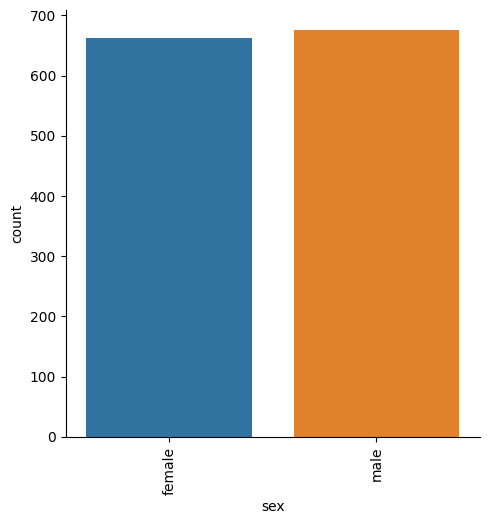

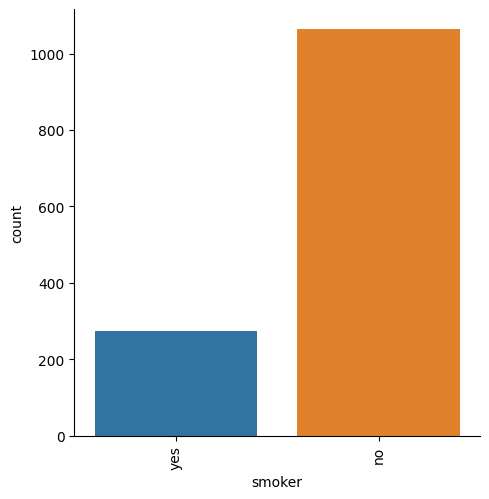

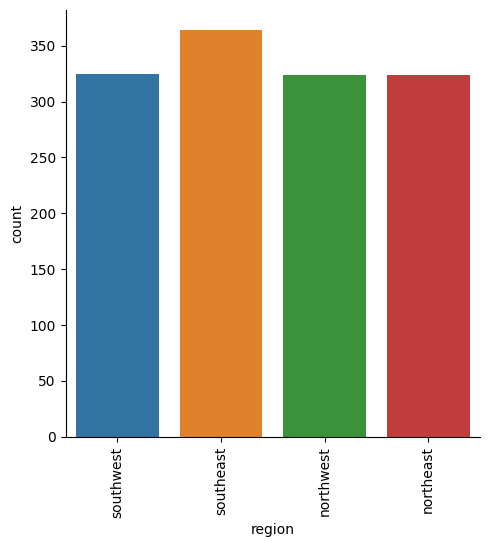

In [13]:
 # 범주형 변수별 개수 시각화
for col in data.select_dtypes(include=['object','category']).columns:
  fig = sns.catplot(x=col, kind="count", data=data, hue=None)
  fig.set_xticklabels(rotation=90)
  plt.show()

In [14]:
# 범주형 데이터 컬럼별 유일한 값 개수 확인하기
###### 코드 작성 부분 시작 ######
# s = pd.DataFrame()
# for col in data.select_dtypes(["object", "category"]).columns:
#     s = pd.concat((s, pd.DataFrame([col, len(data[col].unique()), str(data[col].unique())])), axis = 1)
    # s.append()
    # print([col, len(data[col].unique()), str(data[col].unique())])

# s = s.T
# s.columns = ["columns", "len", "value"]
# display(s)
data.select_dtypes(["object", "category"]).nunique()
###### 코드 작성 부분 마침 ######

sex       2
smoker    2
region    4
dtype: int64

항목이 2개인 성별과, 흡연 여부는 LabelEncoder 를, 지역은 OneHotEncoder 를 사용하기로 한다.

> 범주형 변수 변환

In [15]:
## sklearn 의 LabelEncoder, OneHotEncoder 사용

In [16]:
## LabelEncoder : 각각의 범주를 서로 다른 정수로 맵핑
## 성별, 흡연 여부 컬럼은 Label Encoding 을 위해 ndarray 로 변환하여 준다
sex = data.iloc[:,1:2].values
smoker = data.iloc[:,4:5].values

### 성별 ###
# 1. LabelEncoder() 를 선언해주고
###### 코드 작성 부분 시작 ######
le = LabelEncoder()
###### 코드 작성 부분 마침 ######

# 2. 성별을 LabelEncoder 의 fit_transform 에 넣어준다
###### 코드 작성 부분 시작 ######
sex[:, 0] = le.fit_transform(sex[:, 0])
sex = pd.DataFrame(sex)
sex.columns = ["sex"]
display(sex)
###### 코드 작성 부분 마침 ######

# 3. dict 형으로 변환해주기
###### 코드 작성 부분 시작 ######
le_sex_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_sex_mapping)
###### 코드 작성 부분 마침 ######


sex
0      0
1      1
2      1
3      1
4      1
...   ..
1332   1
1333   0
1334   0
1335   0
1336   0

[1337 rows x 1 columns]

{'female': 0, 'male': 1}


In [17]:
### 흡연 여부 ###
# 1. LabelEncoder() 를 선언해주고
###### 코드 작성 부분 시작 ######

###### 코드 작성 부분 마침 ######

# 2. 흡연 여부를 LabelEncoder 의 fit_transform 에 넣어준다
###### 코드 작성 부분 시작 ######
smoker[:, 0] = le.fit_transform(smoker[:, 0])
smoker = pd.DataFrame(smoker)
smoker.columns = ["smoker"]
print(smoker)
###### 코드 작성 부분 마침 ######

# 3. dict 형으로 변환해주기
###### 코드 작성 부분 시작 ######
le_smoker_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_smoker_mapping)
###### 코드 작성 부분 마침 ######

     smoker
0         1
1         0
2         0
3         0
4         0
...     ...
1332      0
1333      0
1334      0
1335      0
1336      1

[1337 rows x 1 columns]
{'no': 0, 'yes': 1}


In [18]:
## OneHot Encoder : 각각의 범주를 0과 1로 맵핑
## 지역 컬럼은 Label Encoding 을 위해 ndarray 로 변환하여 준다
region = data.iloc[:,5:6].values

### 지역 ###
# 1. OneHotEncoder() 를 선언해주고
###### 코드 작성 부분 시작 ######
ohe = OneHotEncoder()
###### 코드 작성 부분 마침 ######

# 2. 지역을 OneHotEncoder 의 fit_transform 에 넣어준다
###### 코드 작성 부분 시작 ######
region = ohe.fit_transform(region).toarray()
region = pd.DataFrame(region)
display(region)
###### 코드 작성 부분 마침 ######

region.columns = ['northeast', 'northwest', 'southeast', 'southwest']
print("지역에 대한 OneHot Encoder 결과 : ")  
print(region[:10])

# ohe.

0    1    2    3
0     0.0  0.0  0.0  1.0
1     0.0  0.0  1.0  0.0
2     0.0  0.0  1.0  0.0
3     0.0  1.0  0.0  0.0
4     0.0  1.0  0.0  0.0
...   ...  ...  ...  ...
1332  0.0  1.0  0.0  0.0
1333  1.0  0.0  0.0  0.0
1334  0.0  0.0  1.0  0.0
1335  0.0  0.0  0.0  1.0
1336  0.0  1.0  0.0  0.0

[1337 rows x 4 columns]

지역에 대한 OneHot Encoder 결과 : 
   northeast  northwest  southeast  southwest
0        0.0        0.0        0.0        1.0
1        0.0        0.0        1.0        0.0
2        0.0        0.0        1.0        0.0
3        0.0        1.0        0.0        0.0
4        0.0        1.0        0.0        0.0
5        0.0        0.0        1.0        0.0
6        0.0        0.0        1.0        0.0
7        0.0        1.0        0.0        0.0
8        1.0        0.0        0.0        0.0
9        0.0        1.0        0.0        0.0


### 4. 데이터에서 누락된 것이 있는지, 있다면 그것들을 어떻게 처리하려는가?

> NULL 값이 포함된 컬럼 찾기 -> 각 컬럼의 평균값으로 채우기 (Imputation 또는 보간법)

bmi    5
dtype: int64


<AxesSubplot:>

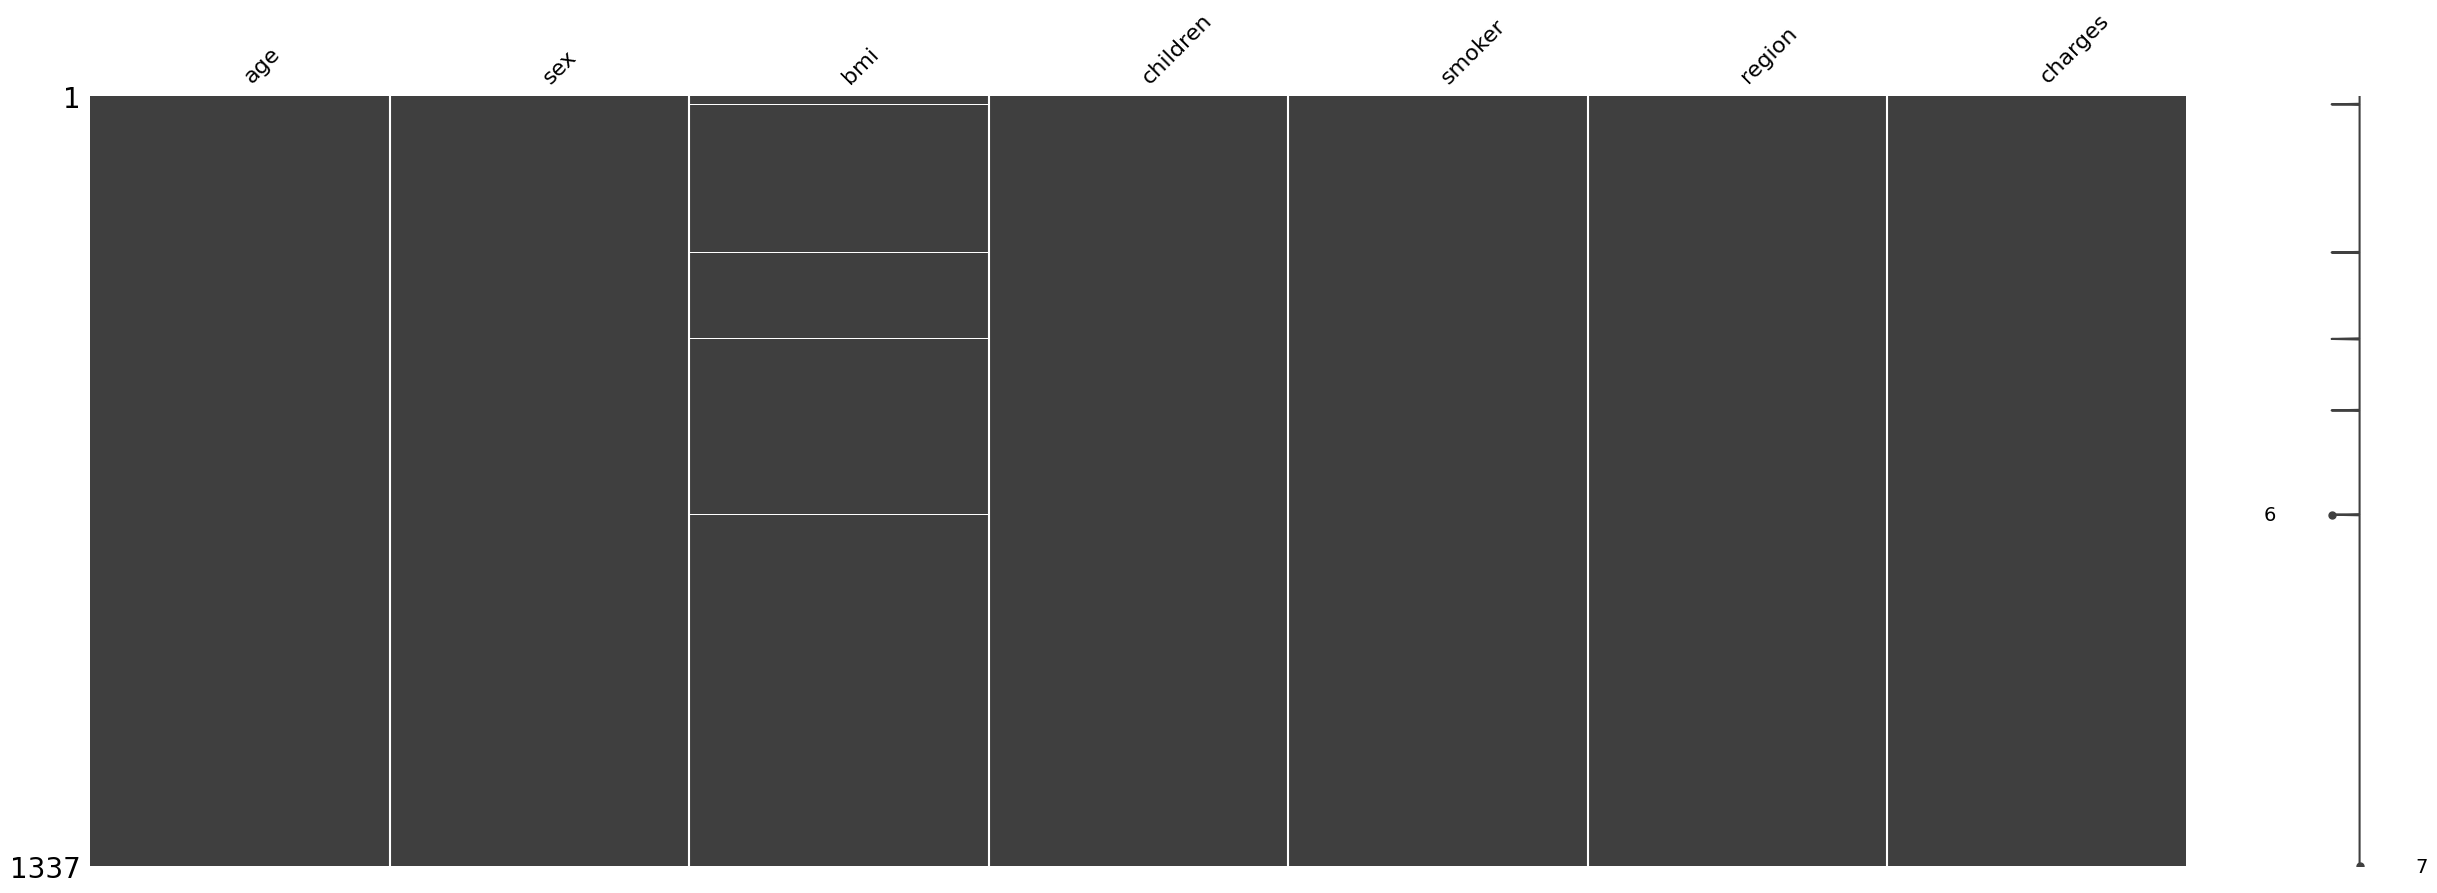

In [19]:
# 각 컬럼들에 몇 개의 NULL 값이 포함되어 있는지 확인
###### 코드 작성 부분 시작 ######
count_nan = data.isnull().sum()
###### 코드 작성 부분 마침 ######
print(count_nan[count_nan > 0])

# missingno 패키지를 통해 시각화 확인
missingno.matrix(data, figsize=(30,10))

<AxesSubplot:>

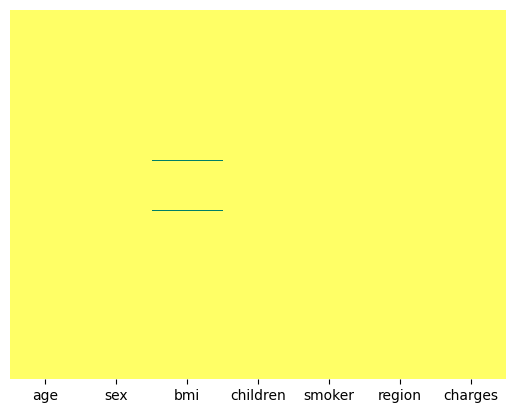

In [20]:
# seaborn 패키지 heatmap 을 통해 시각화 확인
sns.heatmap(data.isnull(), cbar=False, yticklabels=False, cmap='summer_r')

     age     sex  bmi  children smoker     region      charges
14    27    male  NaN         0    yes  southeast  39611.75770
271   50    male  NaN         2    yes  southwest  42856.83800
421   61    male  NaN         0    yes  southeast  46599.10840
545   49    male  NaN         2    yes  northwest  23807.24060
726   29  female  NaN         1    yes  northeast  16657.71745
Series([], dtype: int64)


<AxesSubplot:>

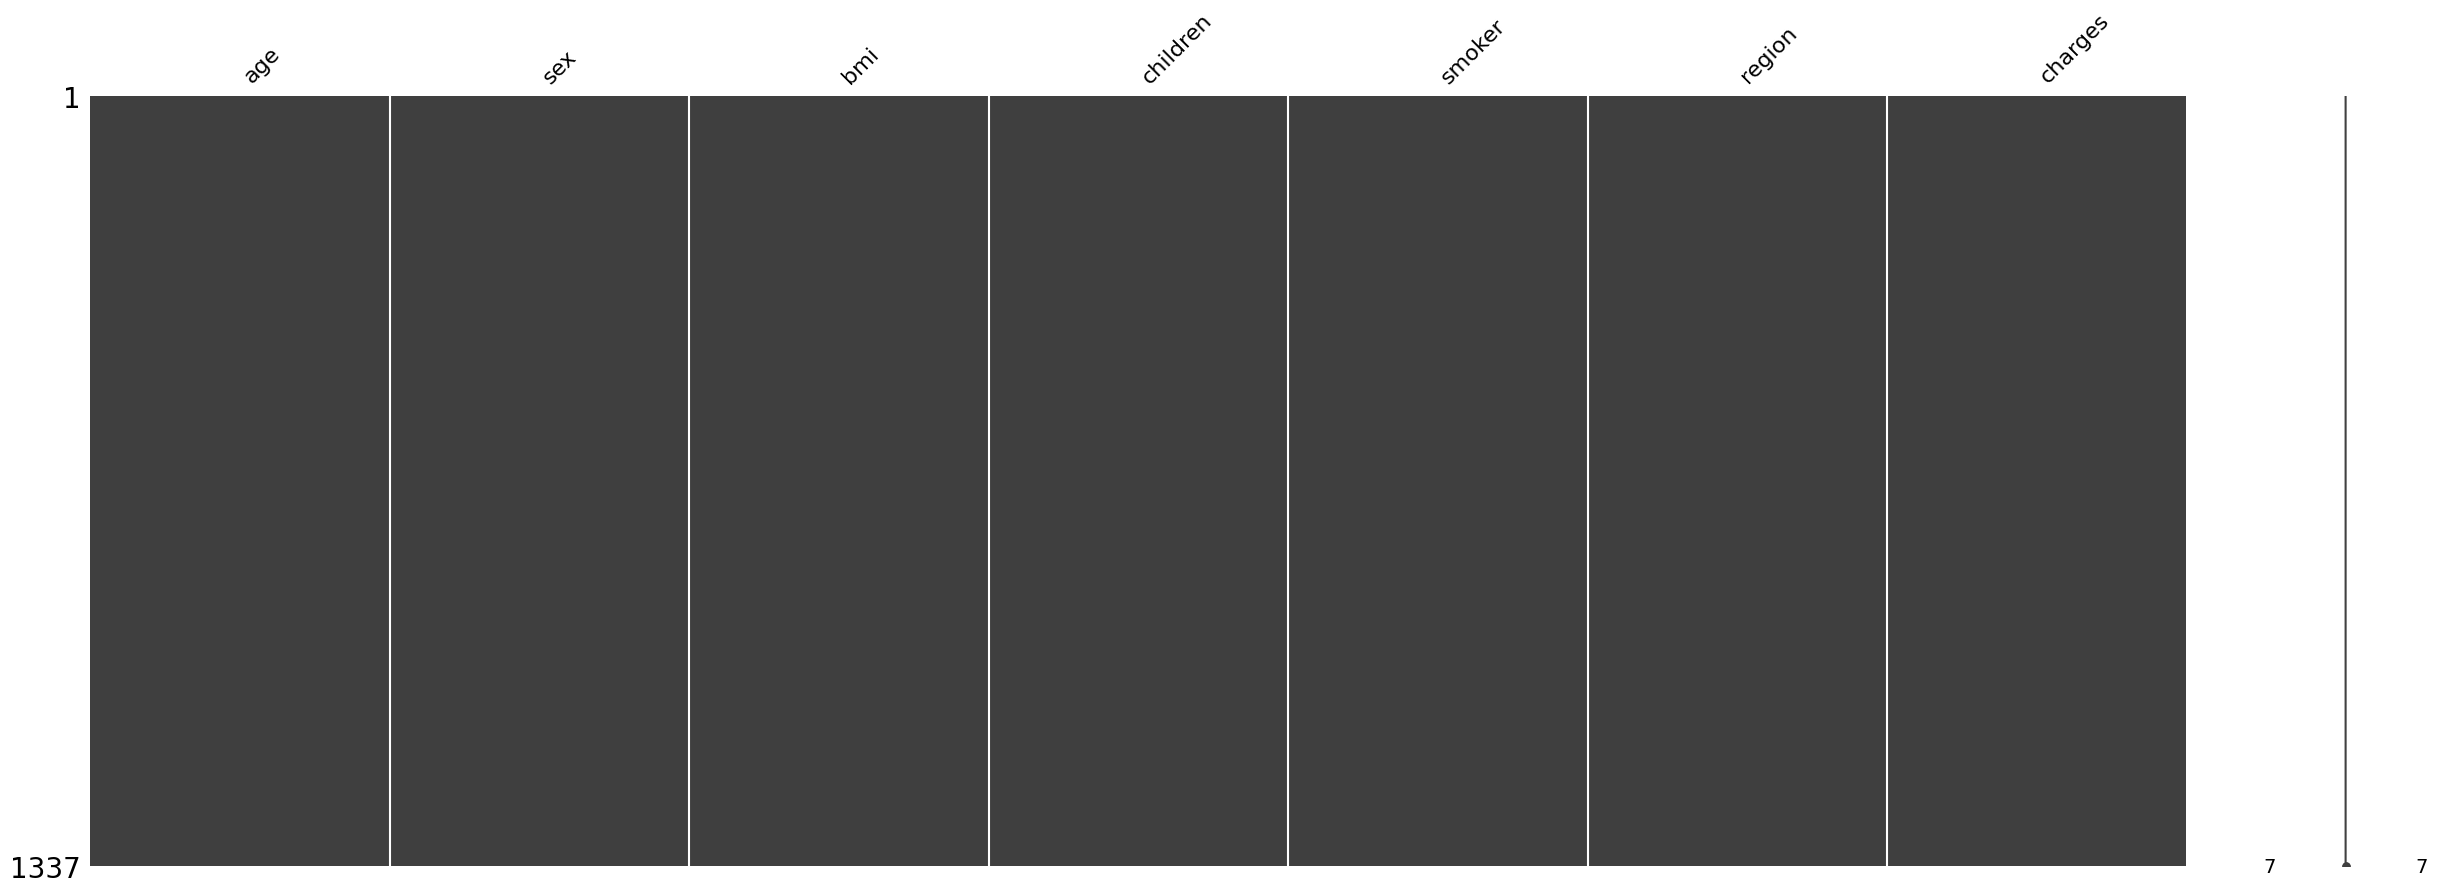

In [21]:
# NULL 값을 해당 컬럼의 평균값으로 대체하기
###### 코드 작성 부분 시작 ######
print(data[data["bmi"].isnull() == True])
data["bmi"].fillna(data["bmi"].mean(), inplace = True)
###### 코드 작성 부분 마침 ######

# 확인
###### 코드 작성 부분 시작 ######
count_nan = data.isnull().sum()
print(count_nan[count_nan > 0])
###### 코드 작성 부분 마침 ######

# missingno 패키지를 통해 시각화 재확인
missingno.matrix(data, figsize=(30,10))

* 결측값 처리 참고 사이트 : https://towardsdatascience.com/how-to-handle-missing-data-8646b18db0d4

### 5. 이상치는 어디에 있는가? 관심을 가져야 할 데이터인가?

> 숫자형 데이터별 요약 통계값 확인

In [22]:
# 데이터 컬럼별 요약 통계값 보기
display(data.describe())

age          bmi     children       charges
count  1337.000000  1337.000000  1337.000000   1337.000000
mean     39.222139    30.658596     1.095737  13279.121487
std      14.044333     6.083657     1.205571  12110.359656
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.315000     0.000000   4746.344000
50%      39.000000    30.400000     1.000000   9386.161300
75%      51.000000    34.600000     2.000000  16657.717450
max      64.000000    53.130000     5.000000  63770.428010

<AxesSubplot:ylabel='Frequency'>

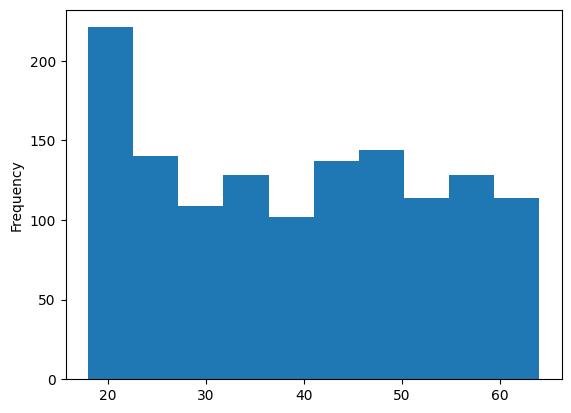

In [34]:
# 데이터 개별 컬럼 히스토그램으로 확인하기
data.age.plot.hist()

<AxesSubplot:ylabel='Frequency'>

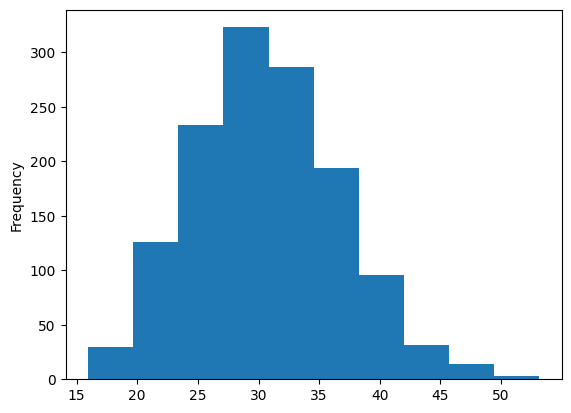

In [35]:
data.bmi.plot.hist()

<AxesSubplot:ylabel='Frequency'>

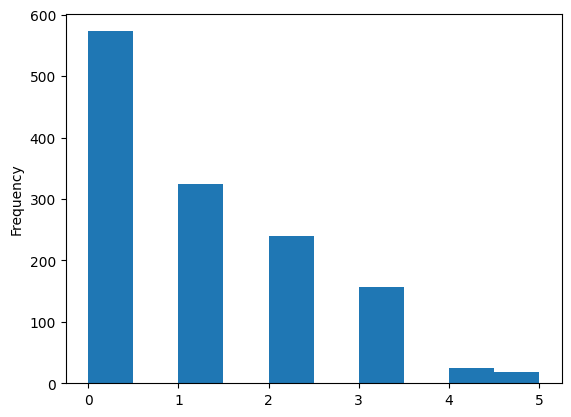

In [36]:
data.children.plot.hist()

<AxesSubplot:ylabel='Frequency'>

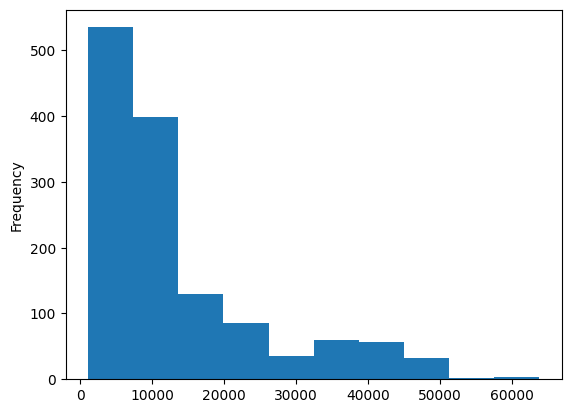

In [37]:
data.charges.plot.hist()

> 숫자형 데이터 Skewness 확인

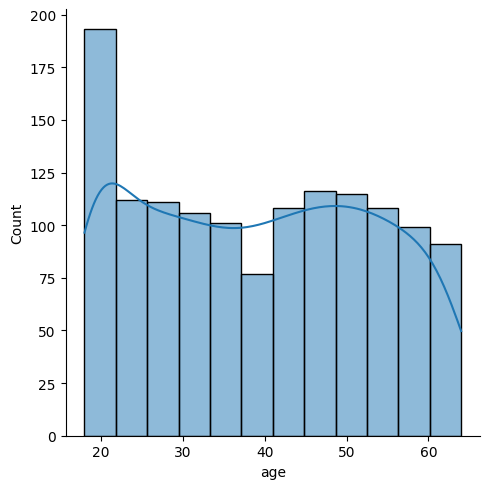

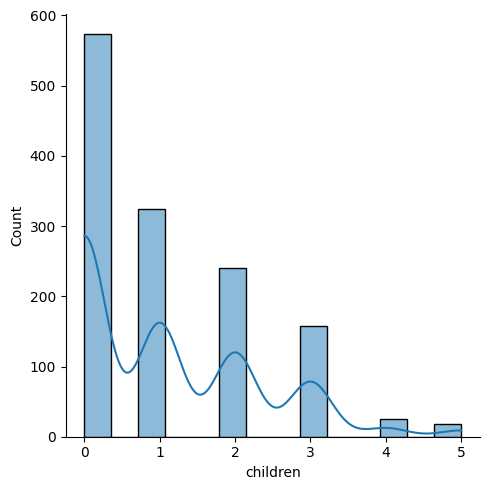

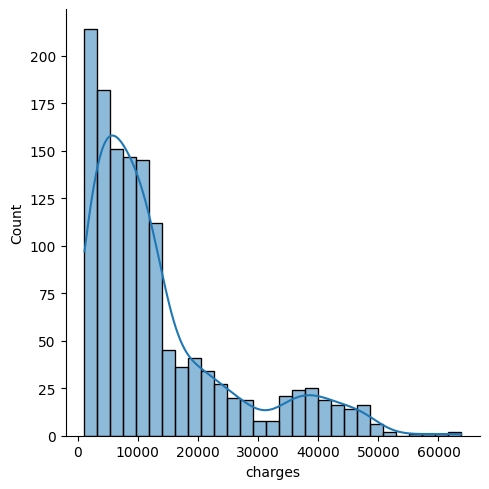

In [47]:
# 데이터 컬럼 타입이 np.number 인 것만 가져오기
###### 코드 작성 부분 시작 ######
numeric_data = data.select_dtypes(include = np.number)
###### 코드 작성 부분 마침 ######

# 데이터 컬럼 타입이 np.number 인 컬럼 이름들 가져오기
l = numeric_data.columns.values

# 컬럼별 히스토그램 그리기
for i in l:
    sns.displot(data[str(i)], kde = True)


> 숫자형 데이터 Box Plot 시각화

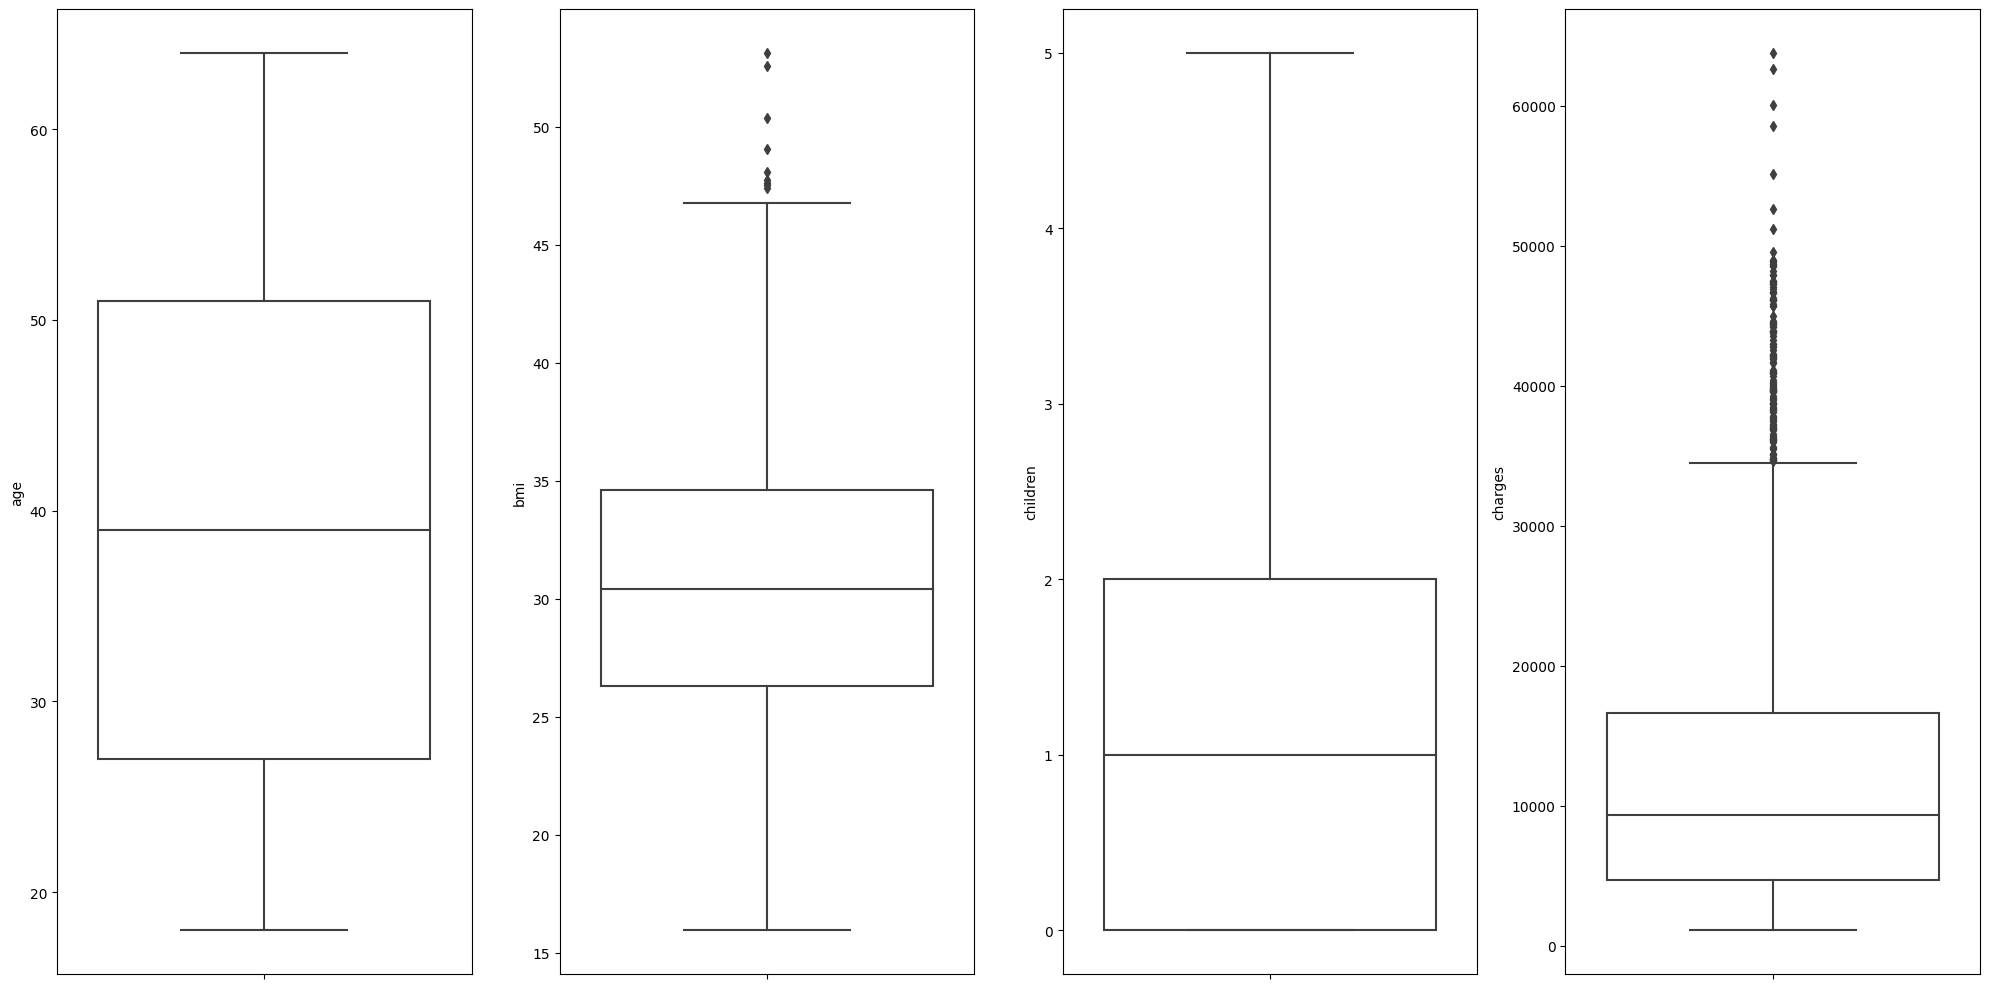

In [49]:
# 데이터 컬럼 타입이 np.number 인 컬럼들 가져오기
num_columns = data.select_dtypes(include = np.number).columns

figure = plt.figure(figsize = (20, 10))
figure.add_subplot(1, len(num_columns), 1)

for index, col in enumerate(num_columns):
    if index > 0:
        figure.add_subplot(1, len(num_columns), index + 1)
    sns.boxplot(y = col, data = data, boxprops = {"facecolor" : "None"})

figure.tight_layout()
plt.show()

> 범주형 데이터별 Violin Plot 시각화

- violin plot
- x 축에 범주형, y 축에 수치형

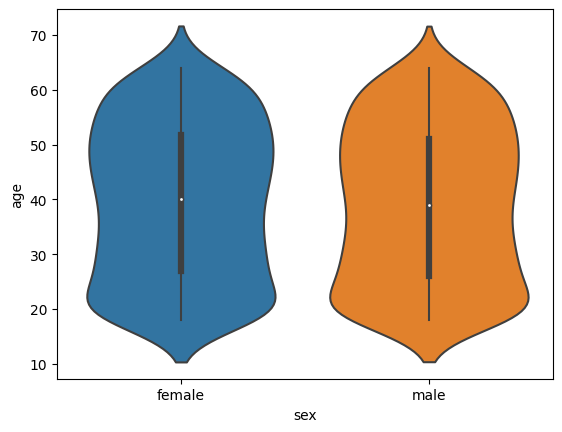

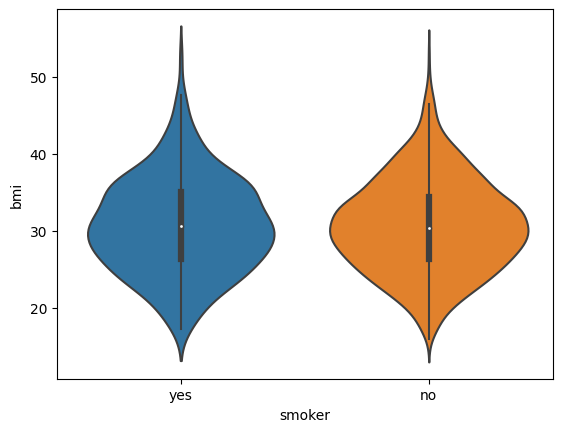

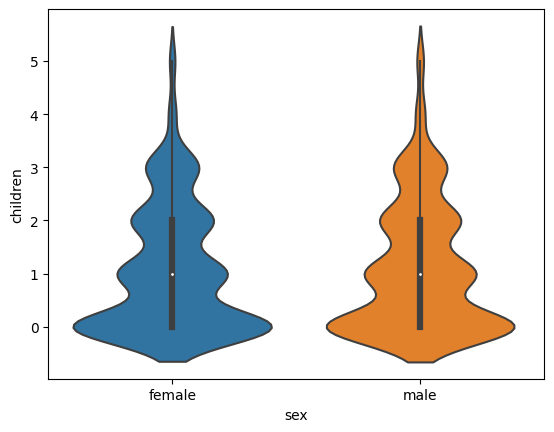

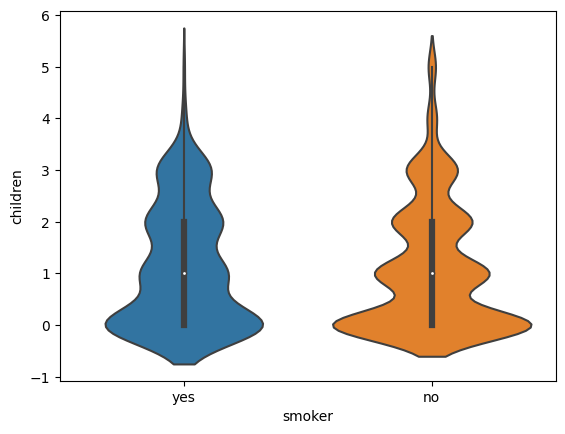

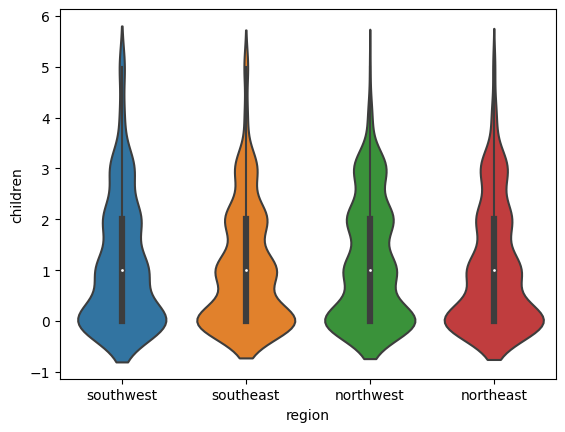

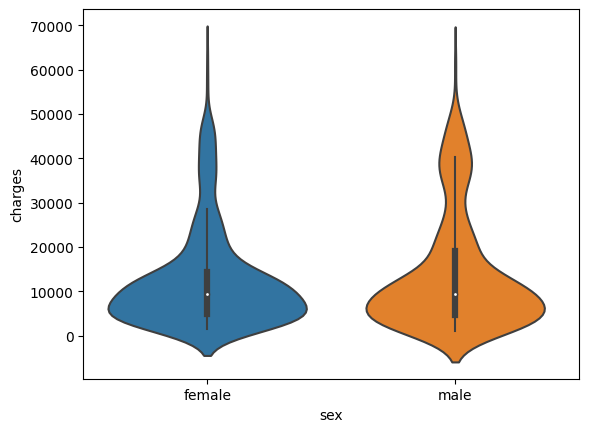

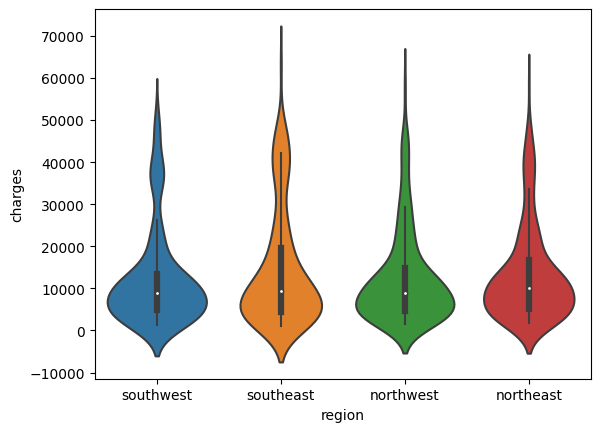

In [64]:
cat_columns = data.select_dtypes(include = ["object", "category"]).columns

# fig = plt.figure(figsize = (20, 10))
# fig.add_subplot(1, len(cat_columns), 1)

# for index, col in enumerate(cat_columns):
#     if index > 0:
#         fig.add_subplot(1, len(cat_columns), index + 1)
#     sns.violinplot(x = str(col), y = "age", data = data)

for num in num_columns:
  for cat in cat_columns:    
      # print(cat, num)
      fig = plt.figure()
      sns.violinplot(x = str(cat), y = str(num), data = data)
      plt.show()

In [56]:
data.loc[:, col]

0       female
1         male
2         male
3         male
4         male
         ...  
1332      male
1333    female
1334    female
1335    female
1336    female
Name: sex, Length: 1337, dtype: object

### 변수 간 상관성이 있는가?

> 숫자형 데이터 간 Pairwise 결합 분포 시각화

c:\Users\rkfka\miniconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


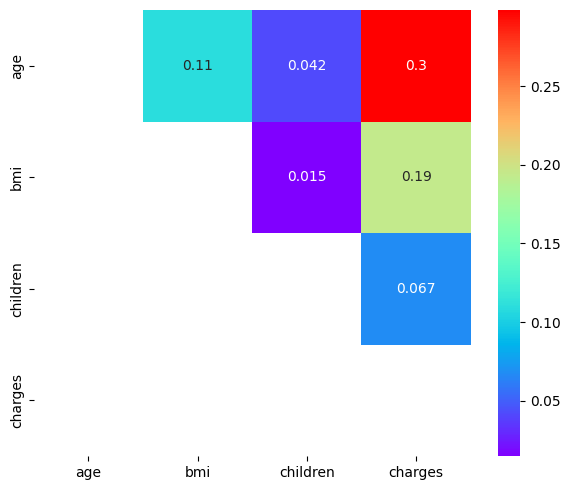

In [102]:
# Seaborn Heatmap 을 사용한 Correlation 시각화

mask = np.zeros_like(data.corr(), dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

fig = plt.figure(figsize = (6,5))
sns.heatmap(data.corr(), annot = True, cmap = "rainbow", mask = mask.T)

plt.tight_layout()
plt.show()

In [97]:
# 보험료 Correlation Matrix 시각화
cols = data.corr().nlargest(len(data.corr()), "charges")["charges"].index
cm = data[cols].corr()

mask = np.zeros_like(data.corr(), dtype = bool)
mask[np.triu_indices_from(mask)] = True

fig = plt.figure(figsize = (6,5))
sns.heatmap(cm, annot = True, cmap = "rainbow", mask = mask.T)
plt.tight_layout()
plt.show()

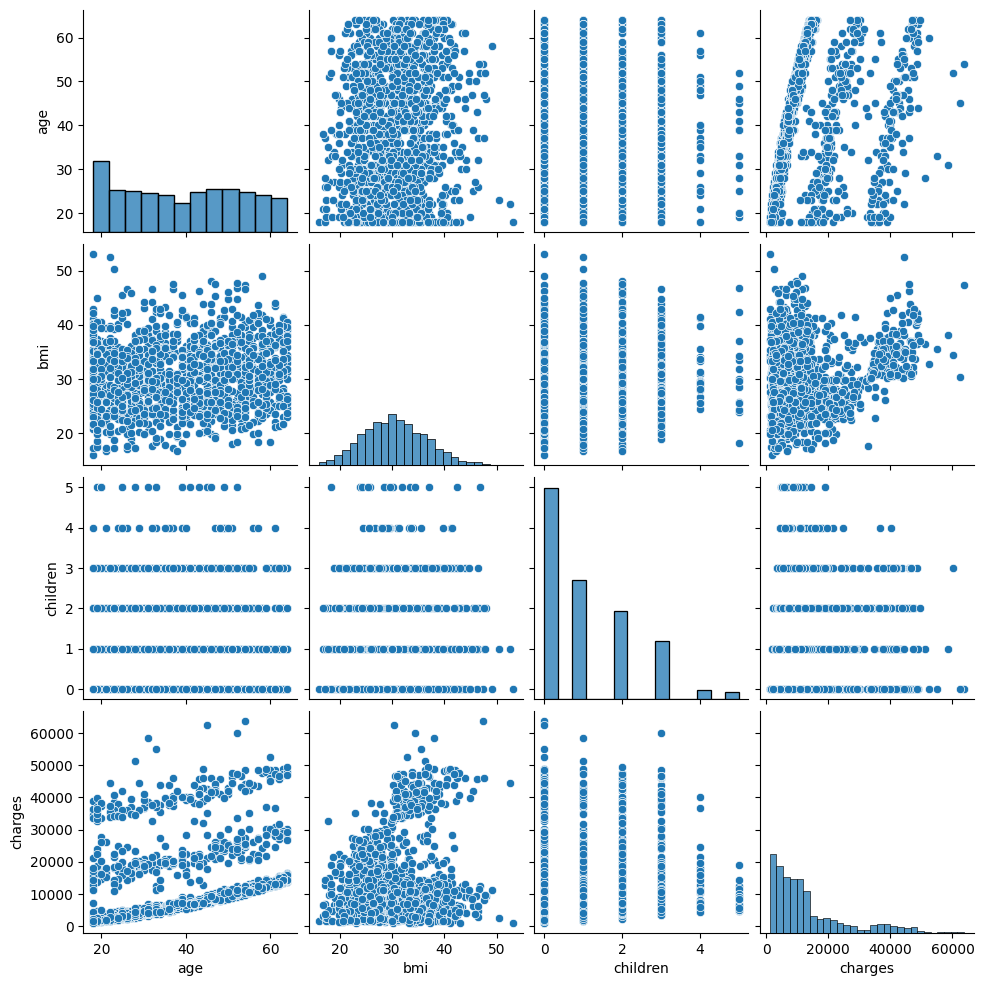

In [103]:
# 숫자 변수형 컬럼들 간 Pairplot 그리기
sns.pairplot(data.select_dtypes(include = np.number))
plt.show()

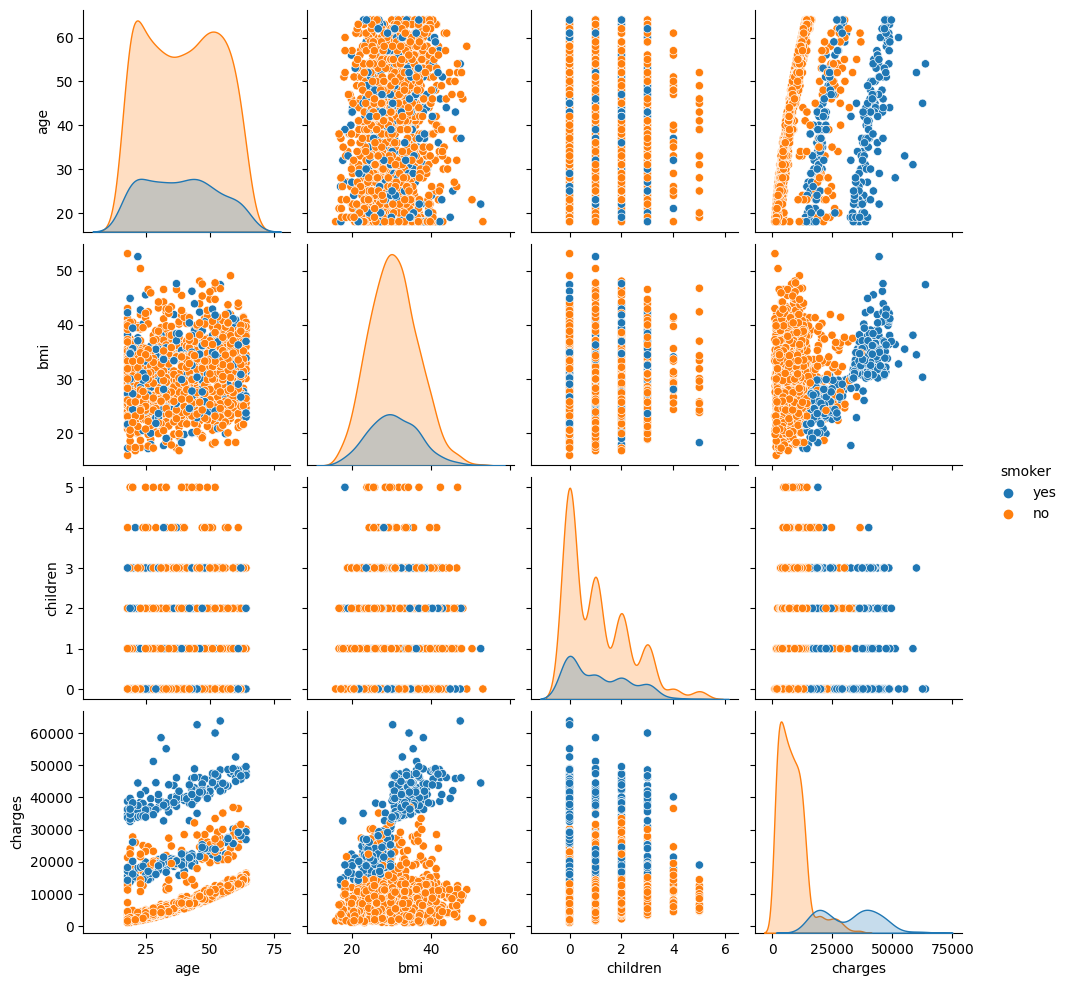

In [105]:
sns.pairplot(data.select_dtypes(include = np.number).join(data["smoker"]), hue = "smoker")
plt.show()

> 범주형 데이터를 기준으로 추가한 시각화

In [33]:
# https://seaborn.pydata.org/examples/index.html


## 03. 다양한 Regression 을 활용한 보험료 예측
---

https://scikit-learn.org/stable/

### Training, Test 데이터 나누기

In [113]:
# 숫자형 데이터들만 copy() 를 사용하여 복사
X_num = data[['age', 'bmi', 'children']].copy()

# 변환했던 범주형 데이터들과 concat 을 사용하여 합치기
X_final = pd.concat([X_num, region, sex, smoker], axis = 1)

# 보험료 컬럼(charges)을 y 값으로 설정
y_final = data[['charges']].copy()

# train_test_split 을 사용하여 Training, Test 나누기 (Training:Test=2:1)
###### 코드 작성 부분 시작 ######
X_train, X_test, y_train, y_test = \
  train_test_split(
    X_final,
    y_final,
    test_size = 0.33,
    random_state = 0
  )
###### 코드 작성 부분 마침 ######

In [114]:
X_train[0:10]

age     bmi  children  northeast  northwest  southeast  southwest sex  \
905    27  32.585         3        1.0        0.0        0.0        0.0   1   
2      28  33.000         3        0.0        0.0        1.0        0.0   1   
405    52  38.380         2        1.0        0.0        0.0        0.0   0   
481    49  37.510         2        0.0        0.0        1.0        0.0   1   
338    50  32.300         1        1.0        0.0        0.0        0.0   1   
356    46  43.890         3        0.0        0.0        1.0        0.0   1   
1258   52  23.180         0        1.0        0.0        0.0        0.0   0   
182    22  19.950         3        1.0        0.0        0.0        0.0   1   
461    42  30.000         0        0.0        0.0        0.0        1.0   1   
1058   32  33.820         1        0.0        1.0        0.0        0.0   1   

     smoker  
905       0  
2         0  
405       0  
481       0  
338       1  
356       0  
1258      0  
182       0  
461       1  
1058      0

In [115]:
X_test[0:10]

age     bmi  children  northeast  northwest  southeast  southwest sex  \
1247   18  39.820         0        0.0        0.0        1.0        0.0   0   
609    47  29.370         1        0.0        0.0        1.0        0.0   0   
393    49  31.350         1        1.0        0.0        0.0        0.0   1   
503    19  30.250         0        0.0        0.0        1.0        0.0   1   
198    51  18.050         0        0.0        1.0        0.0        0.0   0   
820    26  17.670         0        0.0        1.0        0.0        0.0   1   
31     18  26.315         0        1.0        0.0        0.0        0.0   0   
1250   19  19.800         0        0.0        0.0        0.0        1.0   1   
1298   19  25.745         1        0.0        1.0        0.0        0.0   0   
1150   58  36.480         0        0.0        1.0        0.0        0.0   0   

     smoker  
1247      0  
609       0  
393       0  
503       1  
198       0  
820       0  
31        0  
1250      0  
1298      0  
1150      0

### Feature Scaling


*   다차원의 값들을 비교 분석하기 쉽게 만든다.
*   변수들 간의 단위 차이가 있을 경우 필요하다.
*   Overflow, Underflow 를 방지해준다.




https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html?highlight=standardscaler#sklearn.preprocessing.StandardScaler


In [116]:
## MinMaxScaler 를 사용하는 경우 : 이상치가 있는 경우 변환된 값이 매우 좁은 범위로 압축될 수 있다

#n_scaler = MinMaxScaler()
#X_train = n_scaler.fit_transform(X_train.astype(np.float))
#X_test= n_scaler.transform(X_test.astype(np.float))

## StandardScaler 를 사용하는 경우 : 이상치가 있는 경우에는 균형 잡힌 결과를 보장하기 힘들다

###### 코드 작성 부분 시작 ######
s_scaler = StandardScaler()
X_train = s_scaler.fit_transform(X_train.astype(np.float))
X_test = s_scaler.transform(X_test.astype(np.float))
###### 코드 작성 부분 마침 ######

## 그 외 - RobustScaler 를 사용하는 경우 : 이상치의 영향을 최소화한 기법. 중앙값과 IQR 을 사용하기 때문에 표준화 후 동일한 값을 더 넓게 분포시키게 된다.

c:\Users\rkfka\miniconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
c:\Users\rkfka\miniconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == "":


### Regression 절차 요약


*   ****Regression()
*   fit()
*   predict()
*   score()



### Linear Regression 적용

In [117]:
# fit model
###### 코드 작성 부분 시작 ######
lr = LinearRegression().fit(X_train, y_train)
###### 코드 작성 부분 마침 ######

# predict
###### 코드 작성 부분 시작 ######
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
###### 코드 작성 부분 마침 ######

# Score 확인
print("lr.coef_: {}".format(lr.coef_))
print("lr.intercept_: {}".format(lr.intercept_))
print('lr train score %.3f, lr test score: %.3f' % (
lr.score(X_train,y_train),
lr.score(X_test, y_test)))


lr.coef_: [[ 3.32444969e+03  1.77933304e+03  6.18771279e+02  1.89959540e+17
   1.91808540e+17  1.99099628e+17  1.95032656e+17 -3.27738073e+01
   9.52354704e+03]]
lr.intercept_: [13071.56580233]
lr train score 0.742, lr test score: 0.757


### Polynomial Regression 적용

In [118]:
poly = PolynomialFeatures(degree = 3)
X_poly = poly.fit_transform(X_final)

X_train,X_test,y_train,y_test = train_test_split(X_poly,y_final, test_size = 0.33, random_state = 0)

# Standard Scaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train.astype(np.float))
X_test= sc.transform(X_test.astype(np.float))

# fit model
poly_lr = LinearRegression().fit(X_train,y_train)

# predict
y_train_pred = poly_lr.predict(X_train)
y_test_pred = poly_lr.predict(X_test)

# Score 확인
print('poly train score %.3f, poly test score: %.3f' % (
poly_lr.score(X_train,y_train),
poly_lr.score(X_test, y_test)))

poly train score 0.847, poly test score: 0.847


c:\Users\rkfka\miniconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
c:\Users\rkfka\miniconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == "__main__":


### Support Vector Regression 적용

In [119]:
svr = SVR(kernel='linear', C = 300)

X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.33, random_state = 0 )

# Standard Scaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train.astype(np.float))
X_test= sc.transform(X_test.astype(np.float))

# fit model
svr = svr.fit(X_train,y_train.values.ravel())
y_train_pred = svr.predict(X_train)
y_test_pred = svr.predict(X_test)

# Score 확인
print('svr train score %.3f, svr test score: %.3f' % (
svr.score(X_train,y_train),
svr.score(X_test, y_test)))

svr train score 0.715, svr test score: 0.718


c:\Users\rkfka\miniconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys
c:\Users\rkfka\miniconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


### RandomForest Regression 적용

In [122]:
###### 코드 작성 부분 시작 ######
forest = RandomForestRegressor(n_estimators = 100,
                              criterion = "mse",
                              random_state = 1,
                              n_jobs = -1
)
###### 코드 작성 부분 마침 ######

X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.33, random_state = 0 )

# Standard Scaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train.astype(np.float))
X_test= sc.transform(X_test.astype(np.float))

# fit model
forest.fit(X_train,y_train.values.ravel())
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

# Score 확인
print('forest train score %.3f, forest test score: %.3f' % (
forest.score(X_train, y_train),
forest.score(X_test, y_test)))

c:\Users\rkfka\miniconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]
c:\Users\rkfka\miniconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
c:\Users\rkfka\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning:

forest train score 0.975, forest test score: 0.842


### Decision Tree Regression 적용

In [123]:
###### 코드 작성 부분 시작 ######
dt = DecisionTreeRegressor(random_state = 0)
###### 코드 작성 부분 마침 ######

X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.33, random_state = 0 )

# Standard Scaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train.astype(np.float))
X_test= sc.transform(X_test.astype(np.float))

# fit model
dt = dt.fit(X_train,y_train.values.ravel())
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

# Score 확인
print('dt train score %.3f, dt test score: %.3f' % (
dt.score(X_train,y_train),
dt.score(X_test, y_test)))

dt train score 0.999, dt test score: 0.701


c:\Users\rkfka\miniconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == "__main__":
c:\Users\rkfka\miniconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


### 다양한 모델 성능 종합 비교

In [124]:
# 앞에서 만든 regressor 변수들과 라벨을 묶어서 하나의 리스트로 모으기
regressors = [(lr, 'Linear Regression'),
                (poly_lr, 'Polynomial Regression'),
                (svr, 'SupportVector Regression'),
                (forest, 'RandomForest Regression'),
                (dt, 'DecisionTree')]

# 각 regressor 변수들과 라벨 묶음을 차례로 fit -> predict -> score 로 처리해서 보여주기
for reg, label in regressors:
    print(80*'_', '\n')
    reg = reg.fit(X_train,y_train.values.ravel())
    y_train_pred = reg.predict(X_train)
    y_test_pred = reg.predict(X_test)
    print(f'{label} train score %.3f, {label} test score: %.3f' % (
    reg.score(X_train,y_train),
    reg.score(X_test, y_test)))

________________________________________________________________________________ 

Linear Regression train score 0.742, Linear Regression test score: 0.757
________________________________________________________________________________ 

Polynomial Regression train score 0.742, Polynomial Regression test score: 0.757
________________________________________________________________________________ 

SupportVector Regression train score 0.715, SupportVector Regression test score: 0.718
________________________________________________________________________________ 



c:\Users\rkfka\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


RandomForest Regression train score 0.975, RandomForest Regression test score: 0.842
________________________________________________________________________________ 

DecisionTree train score 0.999, DecisionTree test score: 0.701
